In [3]:
import json
import random
from PIL import Image, ImageDraw
import numpy as np
from itertools import cycle
import tiktoken
from collections import namedtuple

In [4]:
class Square:

    
    def __init__(self, x, y, size, level=0):
        self.x = x
        self.y = y
        self.size = size
        self.level = level

    def split(self):
        half = self.size / 2
        level = self.level + 1
        return [
            Square(self.x, self.y, half, level),
            Square(self.x + half, self.y, half, level),
            Square(self.x, self.y + half, half, level),
            Square(self.x + half, self.y + half, half, level)
        ]
    
    def get_rect(self):
        return (int(self.x), int(self.y), int(self.size))
    
    def __str__(self):
        return f"x: {self.x}, y: {self.y}, size: {self.size}"
    
    def __repr__(self):
        return str({"x": self.x, "y": self.y, "size": self.size})

In [5]:
def split_recursively(square, min_size, thr=0.95):
    if square.size <= min_size:
        return [square]

    if random.random() > thr ** square.level:
        return [square]

    squares = square.split()
    result = []
    for square in squares:
        result += split_recursively(square, min_size)

    return result

# Usage
start_square = Square(0, 0, 1024)
squares = split_recursively(start_square, 8, 1)
# for square in squares:
#     print(f'x: {square.x}, y: {square.y}, size: {square.size}, level: {square.level}')

In [6]:
color_table = {
    "mountain": [128, 128, 128],
    "water": [0, 0, 255],
    "forest": [0, 127, 0],
    "field": [127, 127, 0],
    "city": [0, 0, 0],
}

In [7]:
def get_prob_table(top_probs, low_probs, cur_size, top_size=1024, low_size=1):
    cur_probs = {}
    
    # top_size = np.log2(top_size)
    # low_size = np.log2(low_size)
    # cur_size = np.log2(cur_size)
    
    proportion = (cur_size - low_size) / (top_size - low_size)
    
    for k in top_probs:
        cur_probs[k] = (top_probs[k] - low_probs[k]) * proportion + low_probs[k]
    
    return cur_probs

In [8]:
top_size_probs = {
    "mountain": 0.1,
    "water": 0.9,
    "forest": 0.0,
    "field": 0.0,
    "city": 0.0,
}

low_size_probs = {
    "mountain": 0.2,
    "water": 0.2,
    "forest": 0.2,
    "field": 0.3,
    "city": 0.1
}

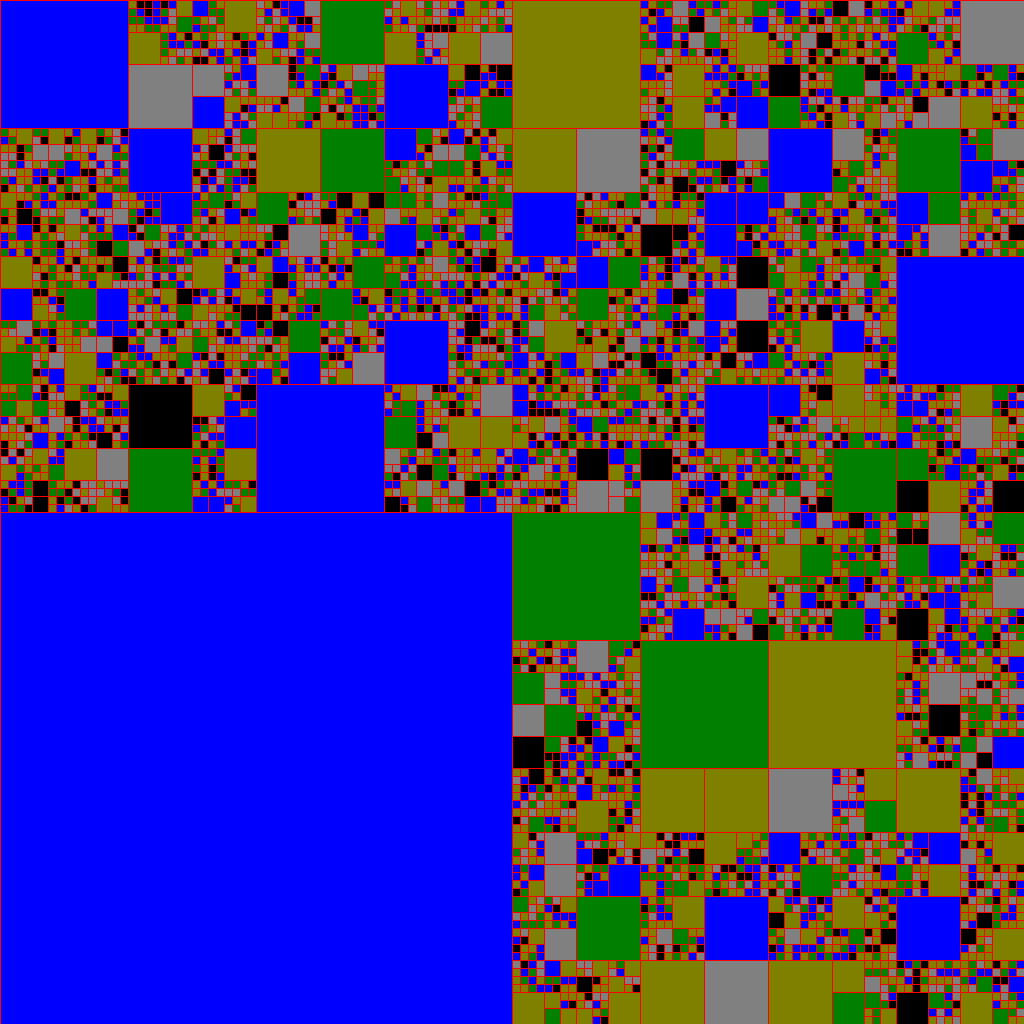

In [9]:
imap = Image.new('RGB', (1024, 1024), color=(0, 0, 0))
draw = ImageDraw.Draw(imap)

for square in squares:
    cur_size_probs = get_prob_table(top_size_probs, low_size_probs, square.size, 1024, 8)
    
    # Convert dictionary into two lists for keys and weights
    keys = list(cur_size_probs.keys())
    probs = list(cur_size_probs.values())

    # Use random.choices to get a key based on the weights
    chosen_key = random.choices(keys, probs)[0]
    
    color = tuple(color_table[chosen_key])
    
    # square_type = np.random.choice(
    # color = tuple(np.random.randint(0, 255, size=3).tolist())
    draw.rectangle([(square.x, square.y), (square.x + square.size, square.y + square.size)], fill=color, outline=(255, 0, 0))

imap